In [1]:
import csv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np
import statistics
from scipy.interpolate import interp1d

#### Figure 2 of the manuscript

In [2]:
def is_within_interfacezone(evlon, evlat, szone):
    # test the interpolatiors
    if szone=='hik':
        finterp = np.load('../subduction-model/finterp/hik_finterp.npy', \
                          allow_pickle=True)[()]
    elif szone=='puy':
        finterp = np.load('../subduction-model/finterp/puy_finterp.npy', \
                          allow_pickle=True)[()]
        
    pbounds = finterp['xbounds']
    if pbounds.contains(Point(evlon, evlat)):
        return True
    return False

In [3]:
def makeplot(X,Y, ax, iax, label_x, ypeak = 800, szone_label = 'Puysegur slab'):
    # medianY= round(statistics.median(Y), 1)
    
    qs = np.percentile(Y, [25, 50, 75])
    
    YQ1, medianY, YQ2 = round(qs[0],1),round(qs[1],1),round(qs[2],1),
    
    xz = [x for x in range(0,300,1)]
    yz = [0 for x in xz]
    ym = [medianY for x in xz]
    # bin-average
    bw = 10
    bx = [x for x in range(bw,int(max(Y)-10),bw)]
    by = []
    for b in bx:
        ty =[]
        for x,y in zip(X,Y):
            if (x>=(b-bw)) & (x<=(b+bw)):
                ty.append(y)
        by.append(round(statistics.median(ty),1))
    
    ax[iax,0].plot(X, Y, '.', markersize= 0.6);
    ax[iax,0].plot(xz, yz, 'k-', linewidth=0.5);
    ax[iax,0].plot(bx, by, 'ks', markerfacecolor='none', markersize=10);
    ax[iax,0].plot(xz, ym, 'r--');

    ax[iax,0].set_xlim([0, 300])
    ax[iax,0].set_ylim([-150, 150])
    ax[iax,0].text(5, -5, 'Interface',  fontsize=14)
    ax[iax,0].text(70, 70, szone_label,  fontsize=14)
    ax[iax,0].set_ylabel('Orthogonal Distance (km)', fontsize=14)
    ax[iax,0].invert_yaxis()

    n = ax[iax,1].hist(Y, int(np.sqrt(len(Y))), orientation='horizontal');
    
    xmax = round(max(n[0])+max(n[0])*0.1)
    
    xz = [x for x in range(0,xmax,1)]
    yz = [0 for x in xz]
    
    ym = [medianY for x in xz]
    ax[iax,1].plot(xz, yz, 'k-', linewidth=0.5);
    ax[iax,1].plot(xz, ym, 'r--');
    
    strlab1 = str(medianY) # + ' (' + str(0.43) +')'
    ax[iax,1].text(xmax-(xmax*0.3),medianY+30, strlab1, c='k',  fontsize=14)
    
   # strlab2 = '[' + str(YQ1)+' ('+ str(0.43) +'), '+ str(YQ2)+' ('+ str(0.34) +')]'
   #  ax[iax,1].text(xmax-(xmax*0.7),medianY+60, strlab2, c='k')
    # ax[iax,1].text(0.5,medianY+20,str(medianY), c='r')
    ax[iax,1].set_ylim([-150, 150]);
    ax[iax,1].set_xlim([0, xmax]);
    ax[iax,1].yaxis.set_ticklabels([])
    ax[iax,1].invert_yaxis()

    ax[iax,1].spines['top'].set_visible(False)
    ax[iax,1].spines['right'].set_visible(False)
    ax[iax,1].spines['bottom'].set_visible(False)
    ax[iax,1].get_xaxis().set_ticks([])

    #ax[iax,1].spines['left'].set_visible(False)
    if label_x:
        ax[iax,0].set_xlabel('Depth (km)',  fontsize=14)
    return n, Y

In [4]:
pfile = 'projected_catalogs/NZeqcat_Rollins13042020-subd-slab-proj2interface.csv'

# lon,lat, dep, mag, year, slat, slon, sdep, dproj
hik_dproj, hik_sdep = [], []
puy_dproj, puy_sdep = [], []

with open(pfile, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        lon = float(row[0])
        lat = float(row[1])
        
        if is_within_interfacezone(lon, lat, 'hik'):
            hik_sdep.append(float(row[7]))
            hik_dproj.append(float(row[8]))
        elif is_within_interfacezone(lon, lat, 'puy'):
            puy_sdep.append(float(row[7]))
            puy_dproj.append(float(row[8]))
            

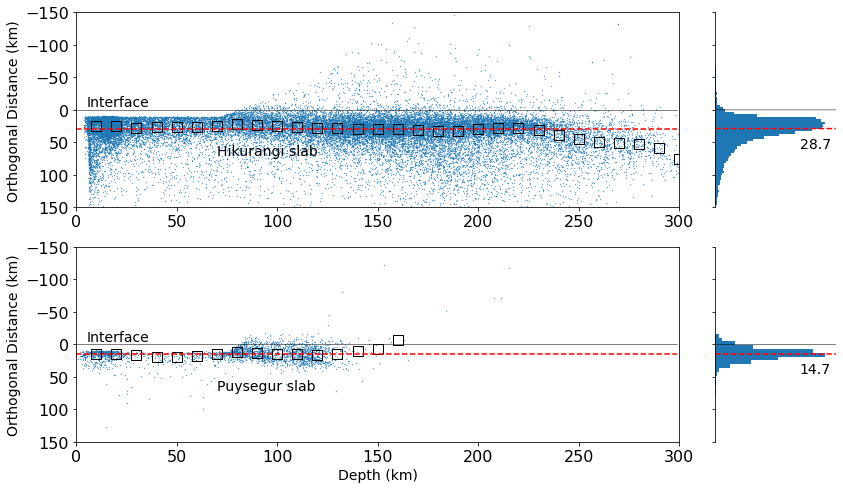

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12,7), gridspec_kw={'width_ratios': [5, 1]})
plt.rcParams.update({'font.size': 16})
n1, Y1 = makeplot(hik_sdep,hik_dproj, ax, iax=0, label_x=False, \
                     ypeak = 800, szone_label = 'Hikurangi slab')
n2, Y2 = makeplot(puy_sdep,puy_dproj, ax, iax=1, label_x=True, \
                     ypeak = 800, szone_label = 'Puysegur slab')

plt.tight_layout()
plt.savefig('Figure2.jpeg', dpi=300, facecolor='w')


To address the hypocentral depth probability distribution, the slab models is constructed with three uniform gridded sheets generated with orthogonal projections from the interface. 

We take a differnt approach, by applying depth probability as weights to the rates, instead of usual probability distrbutions. This formulation has three different spatial points (latitude, longitute and depth) and weights that corresponds to single event rate estimate. 


In [6]:
from scipy import stats

def depthdistr(n, Y):
    # n is bin to estimated porbabily from a point on the histigram
    xx=[]
    nx = n[1] 
    for i in range(len(nx)-1):
        xx.append((nx[i]+nx[i+1])/2.0)
    fx = [x/sum(n[0]) for x in n[0]]
 
    mad = stats.median_abs_deviation(Y, scale=1)
    median = np.median(Y)
    qs = [median-mad, median, median+mad]
    # print(mad)
    kx,kfx = [],[]
    for x,f in zip(xx,fx):
        if x>0.0:
            kx.append(x)
            kfx.append(f)
    
    k_interp = interp1d(xx, fx, kind='cubic')
    p = k_interp(qs)
    plt.plot(kx,kfx)
    plt.plot(qs,p, 'o')
    plt.xlabel('depth (km)')
    plt.ylabel('probability')
    p = [round(x/sum(p),2) for x in p]
    return qs, p

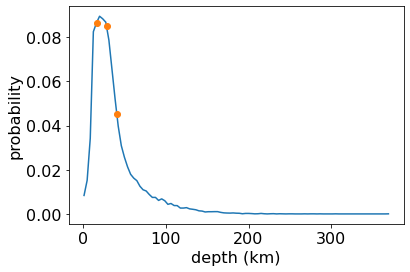

In [7]:
qs, p = depthdistr(n1, Y1);

In [8]:
print('Depth distribution for Hikurangi: depth = ', [round(q,2) for q in qs], 
      'probabilty =', [round(x,2) for x in p])

Depth distribution for Hikurangi: depth =  [16.52, 28.67, 40.82] probabilty = [0.4, 0.39, 0.21]


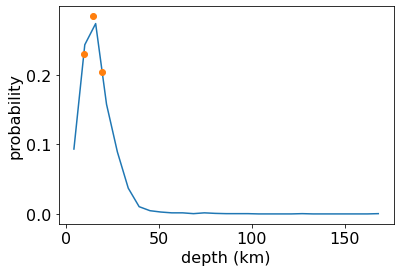

In [9]:
qs, p = depthdistr(n2, Y2)

In [10]:
print('Depth distribution for puysegur: depth = ', [round(q,2) for q in qs], 
      'probabilty =',[round(x,2) for x in p])

Depth distribution for puysegur: depth =  [9.64, 14.68, 19.72] probabilty = [0.32, 0.4, 0.28]
